In [15]:
# IRT Fault Detection: Binary Classification with Custom Metrics and Clear Plots

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import shutil
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import pandas as pd
import io
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import io
from tensorflow.keras.models import load_model
import time
import random

In [16]:
# --- Setup ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 70

In [17]:
# --- Organize Dataset ---
original_data_dir = '/Users/reamy/Desktop/THESIS/BC_dataset'  # Contains 'faulty/' and 'non_faulty/' folders
base_dir = 'data/processed'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [18]:
# Create directories
for split in ['train', 'val']:
    for cls in ['faulty', 'non-faulty']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Split and copy images
for cls in ['faulty', 'non-faulty']:
    cls_dir = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_dir)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_images:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
    for img in val_images:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))


In [19]:
# --- Data Augmentation and Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 182 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


In [9]:
# --- Get True Labels for Callback ---
val_labels = np.concatenate([val_generator[i][1] for i in range(len(val_generator))])

# --- Build Simple CNN Model ---
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001)
model.summary()

# Capture the model summary output
summary_output = io.StringIO()
model.summary(print_fn=lambda x: summary_output.write(x + "\n"))
summary_text = summary_output.getvalue()

# Save the summary to a text file
summary_file_path = os.path.join(os.getcwd(), 'model_summary.txt')
with open(summary_file_path, 'w') as f:
    f.write(summary_text)

print(f"Model summary saved to {summary_file_path}")

/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Model summary saved to /Users/reamy/Desktop/THESIS/SDCNN_BC/model_summary.txt


In [10]:

# --- Compile Model ---
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

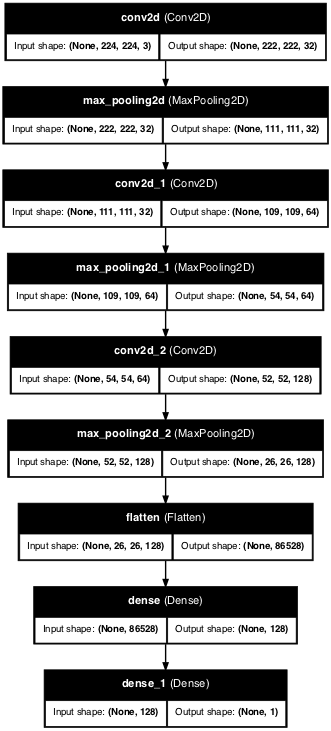

In [11]:
# Save the architecture as an image file in the current working directory
output_path = os.path.join(os.getcwd(), 'model_architecture.png')
plot_model(model, to_file=output_path, show_shapes=True, show_layer_names=True, dpi=50)

# Display the architecture in the notebook
Image(filename=output_path)

In [12]:
# --- Custom Callback to Track Metrics ---
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, val_labels):
        self.val_generator = val_generator
        self.val_labels = val_labels.reshape(-1).astype(int)
        self.results = []

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = model.predict(self.val_generator)
        val_predictions = (val_predictions > 0.5).astype(int).reshape(-1)

        precision = precision_score(self.val_labels, val_predictions)
        recall = recall_score(self.val_labels, val_predictions)
        f1 = f1_score(self.val_labels, val_predictions)

        self.results.append({
            'Epoch': epoch + 1,
            'Training Accuracy': logs['accuracy'],
            'Validation Accuracy': logs['val_accuracy'],
            'Training Loss': logs['loss'],
            'Validation Loss': logs['val_loss'],
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        print(f"Epoch {epoch + 1}: Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

metrics_callback = MetricsCallback(val_generator, val_labels)

In [13]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

# Save the best model only
checkpoint = ModelCheckpoint(
    filepath='best_SDCNN_BC_model.h5',          # file to save the best model
    monitor='val_loss',                # metric to monitor
    save_best_only=True,               # save only if it's the best so far
    mode='min',                        # because we want to minimize loss
    verbose=1                          # print when saving
)

In [14]:
# --- Training the Model ---
#start timer
start_time = time.time()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[metrics_callback,checkpoint, early_stop]
)
# End timer
end_time = time.time()
# Calculate and print elapsed time
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds ({elapsed_time / 60:.2f} minutes).")

/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5132 - auc: 0.5483 - loss: 0.7361 - precision: 0.5035 - recall: 0.
Epoch 1: Precision=0.5610, Recall=1.0000, F1 Score=0.7188

Epoch 1: val_loss improved from inf to 0.66794, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 823ms/step - accuracy: 0.5145 - auc: 0.5552 - loss: 0.7339 - precision: 0.5050 - recall: 0.7521 - val_accuracy: 0.6087 - val_auc: 0.7618 - val_loss: 0.6679 - val_precision: 0.5610 - val_recall: 1.0000
Epoch 2/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step  - accuracy: 0.6500 - auc: 0.6797 - loss: 0.6689 - precision: 0.6368 - recall: 0.9
Epoch 2: Precision=0.7500, Recall=0.1304, F1 Score=0.2222

Epoch 2: val_loss improved from 0.66794 to 0.62035, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 746ms/step - accuracy: 0.6490 - auc: 0.6802 - loss: 0.6685 - precision: 0.6313 - recall: 0.8961 - val_accuracy: 0.5435 - val_auc: 0.8251 - val_loss: 0.6204 - val_precision: 0.7500 - val_recall: 0.1304
Epoch 3/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step  - accuracy: 0.6434 - auc: 0.7966 - loss: 0.6371 - precision: 0.8467 - recall: 0.3
Epoch 3: Precision=0.7419, Recall=1.0000, F1 Score=0.8519

Epoch 3: val_loss improved from 0.62035 to 0.53924, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 775ms/step - accuracy: 0.6512 - auc: 0.7967 - loss: 0.6341 - precision: 0.8401 - recall: 0.4103 - val_accuracy: 0.8261 - val_auc: 0.9074 - val_loss: 0.5392 - val_precision: 0.7419 - val_recall: 1.0000
Epoch 4/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step  - accuracy: 0.7647 - auc: 0.8216 - loss: 0.5703 - precision: 0.7147 - recall: 0.8
Epoch 4: Precision=0.7667, Recall=1.0000, F1 Score=0.8679

Epoch 4: val_loss improved from 0.53924 to 0.45578, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 679ms/step - accuracy: 0.7606 - auc: 0.8172 - loss: 0.5702 - precision: 0.7157 - recall: 0.8410 - val_accuracy: 0.8478 - val_auc: 0.9112 - val_loss: 0.4558 - val_precision: 0.7667 - val_recall: 1.0000
Epoch 5/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step  - accuracy: 0.8234 - auc: 0.9065 - loss: 0.4675 - precision: 0.8001 - recall: 0.8
Epoch 5: Precision=0.7586, Recall=0.9565, F1 Score=0.8462

Epoch 5: val_loss improved from 0.45578 to 0.39188, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 790ms/step - accuracy: 0.8204 - auc: 0.9007 - loss: 0.4702 - precision: 0.7969 - recall: 0.8474 - val_accuracy: 0.8261 - val_auc: 0.9187 - val_loss: 0.3919 - val_precision: 0.7586 - val_recall: 0.9565
Epoch 6/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step  - accuracy: 0.7728 - auc: 0.8105 - loss: 0.4936 - precision: 0.7191 - recall: 0.8
Epoch 6: Precision=0.7419, Recall=1.0000, F1 Score=0.8519

Epoch 6: val_loss did not improve from 0.39188
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 773ms/step - accuracy: 0.7731 - auc: 0.8147 - loss: 0.4912 - precision: 0.7243 - recall: 0.8508 - val_accuracy: 0.8261 - val_auc: 0.9282 - val_loss: 0.4051 - val_precision: 0.7419 - val_recall: 1.0000
Epoch 7/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step  - accuracy: 0.7385 - auc: 0.8117 - loss: 0.5245 - precision: 0.6800 - recall: 0.9
Epoch 7: Precision=0.7857, Recall=0.9565, F1 Score=0.8627

Epoch 7: val_loss improved from 0.39188 to 0.35096, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 686ms/step - accuracy: 0.7429 - auc: 0.8144 - loss: 0.5200 - precision: 0.6842 - recall: 0.9312 - val_accuracy: 0.8478 - val_auc: 0.9338 - val_loss: 0.3510 - val_precision: 0.7857 - val_recall: 0.9565
Epoch 8/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step  - accuracy: 0.7725 - auc: 0.8250 - loss: 0.4753 - precision: 0.7666 - recall: 0.8
Epoch 8: Precision=0.8148, Recall=0.9565, F1 Score=0.8800

Epoch 8: val_loss improved from 0.35096 to 0.33014, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 659ms/step - accuracy: 0.7744 - auc: 0.8304 - loss: 0.4702 - precision: 0.7649 - recall: 0.8126 - val_accuracy: 0.8696 - val_auc: 0.9442 - val_loss: 0.3301 - val_precision: 0.8148 - val_recall: 0.9565
Epoch 9/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step  - accuracy: 0.8067 - auc: 0.9133 - loss: 0.3893 - precision: 0.7873 - recall: 0.8
Epoch 9: Precision=0.8462, Recall=0.9565, F1 Score=0.8980

Epoch 9: val_loss improved from 0.33014 to 0.29966, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 667ms/step - accuracy: 0.8053 - auc: 0.9119 - loss: 0.3898 - precision: 0.7833 - recall: 0.8586 - val_accuracy: 0.8913 - val_auc: 0.9546 - val_loss: 0.2997 - val_precision: 0.8462 - val_recall: 0.9565
Epoch 10/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step  - accuracy: 0.7231 - auc: 0.8310 - loss: 0.4933 - precision: 0.7281 - recall: 0.6
Epoch 10: Precision=0.7419, Recall=1.0000, F1 Score=0.8519

Epoch 10: val_loss did not improve from 0.29966
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 696ms/step - accuracy: 0.7274 - auc: 0.8335 - loss: 0.4894 - precision: 0.7337 - recall: 0.6630 - val_accuracy: 0.8261 - val_auc: 0.9622 - val_loss: 0.3382 - val_precision: 0.7419 - val_recall: 1.0000
Epoch 11/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step  - accuracy: 0.8098 - auc: 0.8768 - loss: 0.4459 - precision: 0.7626 - recall: 0.9
Epoch 11: Precision=0.8800, Recall=0.9565, F1 Score=0.9167

Epoch 11: val_loss improved from 0.29966 to 0.28807, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 752ms/step - accuracy: 0.8079 - auc: 0.8765 - loss: 0.4435 - precision: 0.7645 - recall: 0.8931 - val_accuracy: 0.9130 - val_auc: 0.9669 - val_loss: 0.2881 - val_precision: 0.8800 - val_recall: 0.9565
Epoch 12/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step  - accuracy: 0.8521 - auc: 0.9105 - loss: 0.3782 - precision: 0.8290 - recall: 0.9
Epoch 12: Precision=0.8519, Recall=1.0000, F1 Score=0.9200

Epoch 12: val_loss improved from 0.28807 to 0.27480, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 732ms/step - accuracy: 0.8489 - auc: 0.9084 - loss: 0.3804 - precision: 0.8196 - recall: 0.9263 - val_accuracy: 0.9130 - val_auc: 0.9584 - val_loss: 0.2748 - val_precision: 0.8519 - val_recall: 1.0000
Epoch 13/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step  - accuracy: 0.7778 - auc: 0.8822 - loss: 0.4355 - precision: 0.7687 - recall: 0.7
Epoch 13: Precision=0.7419, Recall=1.0000, F1 Score=0.8519

Epoch 13: val_loss did not improve from 0.27480
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 709ms/step - accuracy: 0.7789 - auc: 0.8841 - loss: 0.4332 - precision: 0.7767 - recall: 0.7377 - val_accuracy: 0.8261 - val_auc: 0.9461 - val_loss: 0.3154 - val_precision: 0.7419 - val_recall: 1.0000
Epoch 14/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step  - accuracy: 0.8399 - auc: 0.8678 - loss: 0.4423 - precision: 0.7726 - recall: 0.9
Epoch 14: Precision=0.8800, Recall=0.9565, F1 Score=0.9167

Epoch 14: val_loss improved from 0.27480 to 0.27323, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 693ms/step - accuracy: 0.8384 - auc: 0.8731 - loss: 0.4400 - precision: 0.7694 - recall: 0.9969 - val_accuracy: 0.9130 - val_auc: 0.9490 - val_loss: 0.2732 - val_precision: 0.8800 - val_recall: 0.9565
Epoch 15/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step  - accuracy: 0.8651 - auc: 0.9482 - loss: 0.3428 - precision: 0.9363 - recall: 0.8
Epoch 15: Precision=0.8800, Recall=0.9565, F1 Score=0.9167

Epoch 15: val_loss improved from 0.27323 to 0.26413, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 773ms/step - accuracy: 0.8639 - auc: 0.9453 - loss: 0.3446 - precision: 0.9273 - recall: 0.8320 - val_accuracy: 0.9130 - val_auc: 0.9499 - val_loss: 0.2641 - val_precision: 0.8800 - val_recall: 0.9565
Epoch 16/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step  - accuracy: 0.7890 - auc: 0.9045 - loss: 0.3728 - precision: 0.7601 - recall: 0.7
Epoch 16: Precision=0.8846, Recall=1.0000, F1 Score=0.9388

Epoch 16: val_loss improved from 0.26413 to 0.25337, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 728ms/step - accuracy: 0.7925 - auc: 0.9057 - loss: 0.3705 - precision: 0.7649 - recall: 0.8028 - val_accuracy: 0.9348 - val_auc: 0.9442 - val_loss: 0.2534 - val_precision: 0.8846 - val_recall: 1.0000
Epoch 17/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step  - accuracy: 0.8760 - auc: 0.9343 - loss: 0.3238 - precision: 0.8405 - recall: 0.9
Epoch 17: Precision=0.9130, Recall=0.9130, F1 Score=0.9130

Epoch 17: val_loss did not improve from 0.25337
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 651ms/step - accuracy: 0.8773 - auc: 0.9356 - loss: 0.3217 - precision: 0.8418 - recall: 0.9464 - val_accuracy: 0.9130 - val_auc: 0.9471 - val_loss: 0.2691 - val_precision: 0.9130 - val_recall: 0.9130
Epoch 18/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step  - accuracy: 0.8146 - auc: 0.9236 - loss: 0.3545 - precision: 0.8203 - recall: 0.8
Epoch 18: Precision=0.8846, Recall=1.0000, F1 Score=0.9388

Epoch 18: val_loss improved from 0.25337 to 0.23207, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 708ms/step - accuracy: 0.8152 - auc: 0.9238 - loss: 0.3531 - precision: 0.8196 - recall: 0.8162 - val_accuracy: 0.9348 - val_auc: 0.9499 - val_loss: 0.2321 - val_precision: 0.8846 - val_recall: 1.0000
Epoch 19/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step  - accuracy: 0.8904 - auc: 0.9361 - loss: 0.3204 - precision: 0.8363 - recall: 0.9
Epoch 19: Precision=0.9130, Recall=0.9130, F1 Score=0.9130

Epoch 19: val_loss did not improve from 0.23207
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 664ms/step - accuracy: 0.8856 - auc: 0.9336 - loss: 0.3251 - precision: 0.8301 - recall: 0.9654 - val_accuracy: 0.9130 - val_auc: 0.9527 - val_loss: 0.2348 - val_precision: 0.9130 - val_recall: 0.9130
Epoch 20/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step  - accuracy: 0.8602 - auc: 0.9116 - loss: 0.3611 - precision: 0.8523 - recall: 0.8
Epoch 20: Precision=0.8846, Recall=1.0000, F1 Score=0.9388

Epoch 20: val_loss improved from 0.23207 to 0.21580, saving model to best_SDCNN_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 676ms/step - accuracy: 0.8621 - auc: 0.9138 - loss: 0.3574 - precision: 0.8548 - recall: 0.8884 - val_accuracy: 0.9348 - val_auc: 0.9565 - val_loss: 0.2158 - val_precision: 0.8846 - val_recall: 1.0000
Epoch 21/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step  - accuracy: 0.8926 - auc: 0.9483 - loss: 0.3019 - precision: 0.8310 - recall: 0.9
Epoch 21: Precision=0.9167, Recall=0.9565, F1 Score=0.9362

Epoch 21: val_loss did not improve from 0.21580
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 691ms/step - accuracy: 0.8907 - auc: 0.9460 - loss: 0.3049 - precision: 0.8307 - recall: 0.9793 - val_accuracy: 0.9348 - val_auc: 0.9556 - val_loss: 0.2268 - val_precision: 0.9167 - val_recall: 0.9565
Epoch 22/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step  - accuracy: 0.8849 - auc: 0.9283 - loss: 0.3180 - precision: 0.8735 - recall: 0.8
Epoch 22: Precision=0.8519, Recall=1.0000, F1 Score=0.9200

Epoch 22: val_loss did not improve from 0.21580
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 694ms/step - accuracy: 0.8817 - 

In [15]:
# --- Save Metrics to CSV ---
results_df = pd.DataFrame(metrics_callback.results)
results_file_path = os.path.join(os.getcwd(), 'training_results.csv')
results_df.to_csv(results_file_path, index=False)
print(f"Training results saved to {results_file_path}")

# --- Plotting Metrics ---
metrics = ['Precision', 'Recall', 'F1 Score', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']
titles = ['Precision', 'Recall', 'F1 Score', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']
file_names = ['precision_plot.png', 'recall_plot.png', 'f1_score_plot.png',
              'training_accuracy_plot.png', 'validation_accuracy_plot.png',
              'training_loss_plot.png', 'validation_loss_plot.png']

for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 5))
    plt.plot(results_df[metric], label=metric, linewidth=2, color='blue')
    plt.title(titles[i], fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    # Annotate last value
    last_epoch = len(results_df[metric]) - 1
    last_value = results_df[metric].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

    plt.tight_layout()
    plt.savefig(file_names[i], dpi=300)
    plt.close()

print("All plots saved successfully.")

Training results saved to /Users/reamy/Desktop/THESIS/SDCNN_BC/training_results.csv
All plots saved successfully.


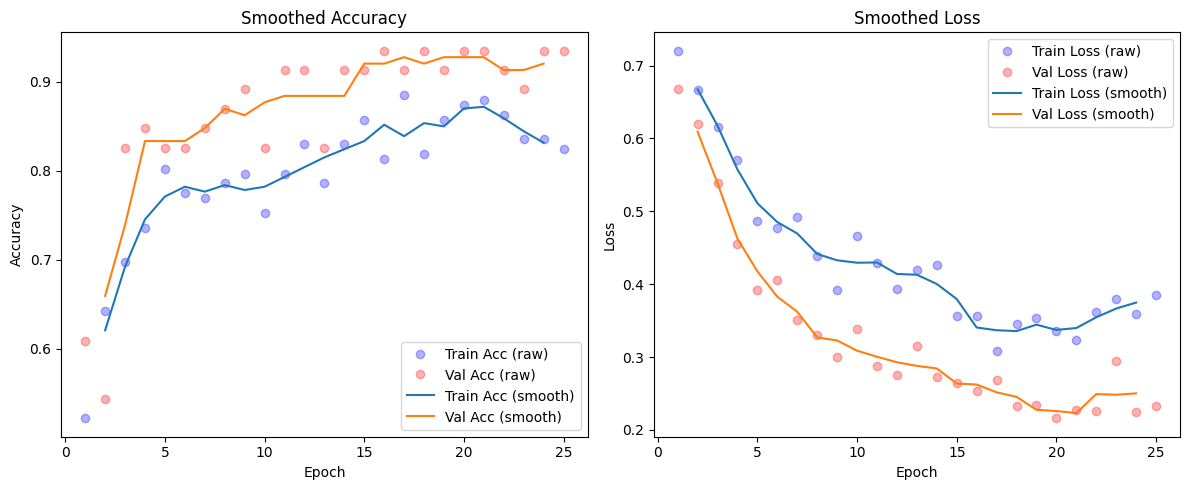

In [16]:
# --- Plotting Smoothed Metrics ---

def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Example with your training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Smoothed accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', alpha=0.3, label='Train Acc (raw)')
plt.plot(epochs, val_acc, 'ro', alpha=0.3, label='Val Acc (raw)')
plt.plot(epochs[1:-1], moving_average(acc), label='Train Acc (smooth)')
plt.plot(epochs[1:-1], moving_average(val_acc), label='Val Acc (smooth)')
plt.title('Smoothed Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Smoothed loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', alpha=0.3, label='Train Loss (raw)')
plt.plot(epochs, val_loss, 'ro', alpha=0.3, label='Val Loss (raw)')
plt.plot(epochs[1:-1], moving_average(loss), label='Train Loss (smooth)')
plt.plot(epochs[1:-1], moving_average(val_loss), label='Val Loss (smooth)')
plt.title('Smoothed Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

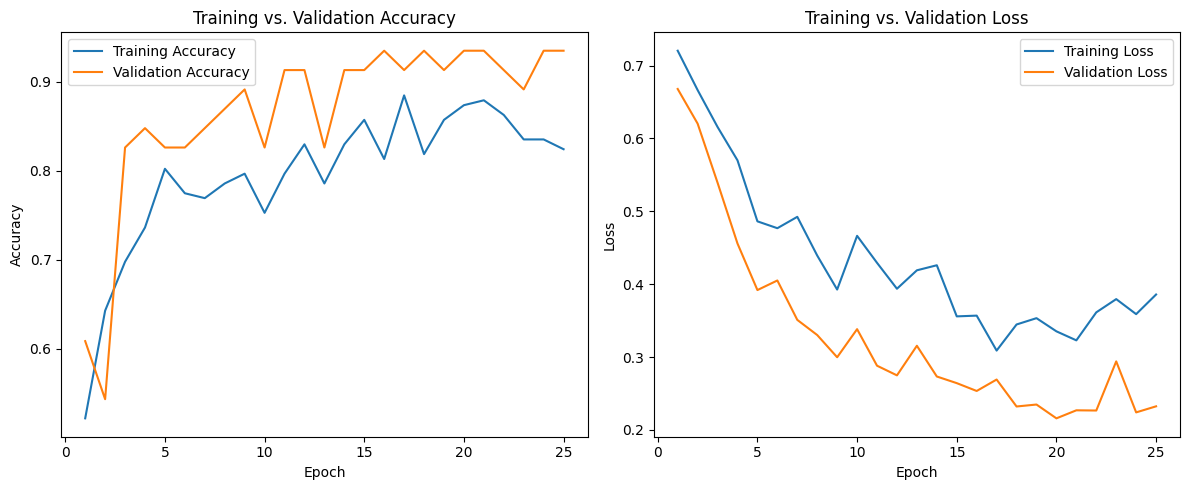

In [17]:


# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:


# --- Plot Accuracy (Training + Validation) ---
plt.figure(figsize=(8, 5))
plt.plot(results_df['Training Accuracy'], label='Training Accuracy', linewidth=2, color='blue')
plt.plot(results_df['Validation Accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# Annotate last values
for label in ['Training Accuracy', 'Validation Accuracy']:
    last_epoch = len(results_df[label]) - 1
    last_value = results_df[label].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value + 0.02),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

plt.tight_layout()
plt.savefig('sdcnn1_accuracy_combined.png', dpi=300)
plt.close()

# --- Plot Loss (Training + Validation) ---
plt.figure(figsize=(8, 5))
plt.plot(results_df['Training Loss'], label='Training Loss', linewidth=2, color='green')
plt.plot(results_df['Validation Loss'], label='Validation Loss', linewidth=2, color='firebrick')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# Annotate last values
# Improved annotation to prevent overlap
labels = ['Training Loss', 'Validation Loss']
offsets = [0.02, -0.03]  # One above, one below

for label, offset in zip(labels, offsets):
    last_epoch = len(results_df[label]) - 1
    last_value = results_df[label].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value + offset),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

plt.tight_layout()
plt.savefig('sdcnn1_loss_combined.png', dpi=300)
plt.close()


print("Combined accuracy and loss plots saved successfully.")

Combined accuracy and loss plots saved successfully.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


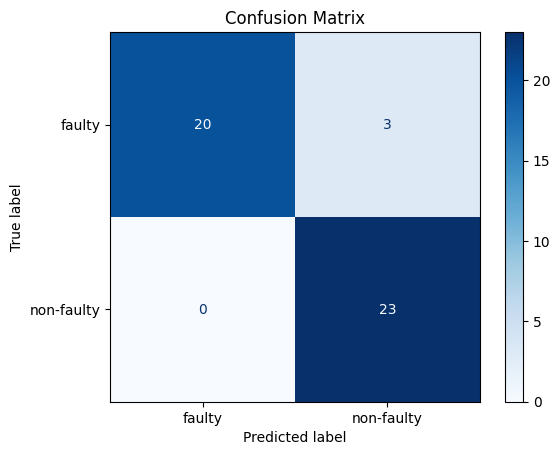

In [19]:
# --- Confusion Matrix ---
predictions = model.predict(val_generator)
y_pred = (predictions > 0.5).astype(int).reshape(-1)
cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


In [24]:
detection_sdcnn = load_model("/Users/reamy/Desktop/THESIS/SDCNN_BC/best_SDCNN_BC_model.h5")

In [25]:
# Collect all validation images and labels
# Initialize lists to store images and labels
val_gen=val_generator
X_val = []
y_val = []
val_gen.reset()
# Go through all batches
for _ in range(val_gen.samples // val_gen.batch_size + 1):
    try:
        imgs, labels = next(val_gen)
        for img, label in zip(imgs, labels):
            X_val.append(img)
            y_val.append(label)
    except StopIteration:
        break

X_val = np.array(X_val)
y_val = np.array(y_val)

# Class labels
class_labels_detection = ['Faulty', 'Non-Faulty']

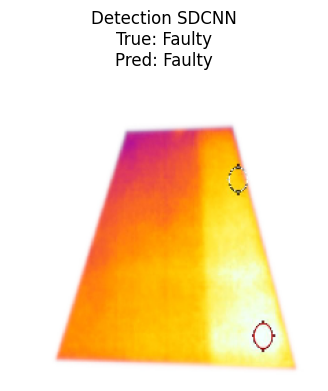

Detection SDCNN Prediction: Faulty
----------------------------------------


In [47]:

class_labels_detection = ['Faulty', 'Non-Faulty']

# Randomly select 5 indices
indices = random.sample(range(len(X_val)), 5)

# Predict and plot
for idx in indices:
    img = X_val[idx]
    label = y_val[idx]

    image_batch = np.expand_dims(img, axis=0)  # Make batch shape (1, 224, 224, 3)

    # Predict using each model
    Detection_SDCNN1= detection_sdcnn.predict(image_batch, verbose=0)[0]
 

    # Convert predictions to labels
    Detection_SDCNN1 = class_labels_detection[np.argmax(det_pred1)]
   

    # True labels
# True labels
if isinstance(label, (np.ndarray, list)) and len(label) > 1:
    true_label = np.argmax(label)
    true_det_label = class_labels_detection[true_label] if len(label) == 2 else 'N/A'
    true_diag_label = class_labels_diagnosis[true_label] if len(label) == 4 else 'N/A'
else:
    true_label = int(label)
    true_det_label = class_labels_detection[true_label]
    true_diag_label = 'N/A'


    # Plot image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Detection SDCNN\nTrue: {true_det_label if true_det_label != 'N/A' else true_diag_label}\nPred: {pred_det1}")
    plt.show()

    # Print predictions
    print(f"Detection SDCNN Prediction: {pred_det1}")
   
    print("-" * 40)